# Demonstration of fitting a nonlinear STRF using NEMS

This is a work in progress and will be used to showcase current progress towards integrating the `Recording` and `Signal` objects into NEMS. Once this is better integrated, then this notebook will serve as a tutorial showing the *internals* of NEMS (i.e., don't hide anything behind magic `do_fit` functions). By exposing the internals, it makes it easy for someone learning the system to explore the various objects interactively.

## Issues with Baphy

Baphy only saves data on a per-trial basis. This means that we do not have information about what occurs in between trials. However, the `Recording` datastructure expects data to be a two-dimensional array of channel x time. Epoch information is stored in an dataframe which can be used to pull trials out of the recording.

In [64]:
import os.path

from nems.utilities import io

# This is a utility function that I wrote to convert arrays to the Recording format.
from baphy_to_recording import arrays_to_recording

In [65]:
cellid = "TAR010c-21-2"     # identifier for this data set
batch = 0                   # batch of data sets that this set belongs to
modelname = "wc02_fir_dexp" # string identifier for this model architecture

# This stuff is LBHB specific.
base_url = "https://s3-us-west-2.amazonaws.com/nemspublic/sample_data/"
stim_template = '{}_NAT_stim_ozgf_c18_fs100.mat'.format(cellid)
resp_template = '{}_NAT_resp_fs100.mat'.format(cellid)

stimfile = os.path.join(base_url, stim_template)
respfile = os.path.join(base_url, resp_template)

stim = io.load_matlab_matrix(stimfile, key="stim", label="stim", channelaxis=0, eventaxis=1, timeaxis=2)
resp = io.load_matlab_matrix(respfile, key="psth", label="resp", repaxis=None, eventaxis=1, timeaxis=2)

arrays = {'pred': stim, 'resp': resp}
recording = arrays_to_recording(arrays, 100, cellid)

In [75]:
# The first 3 recordings are validation data (just how Stephen saved the data)
val, est = recording.split_at_rep(0.03)

In [28]:
import nems.stack as ns
import nems.modules as nm
import nems.utilities as nu
import nems.fitters as nf

# Initialize stack and data
stack = ns.nems_stack(cellid=cellid, batch=batch, modelname=modelname)
stack.set_data(est)

# Create the modules.
mod_wc = nm.filters.WeightChannels(stack, output_channels=2)
mod_fir = nm.filters.FIR(stack, num_coefs=15)
mod_gain = nm.nonlin.gain(stack, nltype='dexp')
mod_mse = nm.metrics.mean_square_error(stack)

nems.stack, 73 : Creating new stack

nems.modules.base, 25 : creating module filters.weight_channels

nems.modules.base, 25 : creating module filters.fir

nems.modules.base, 25 : creating module nonlin.gain

nems.modules.base, 25 : creating module metrics.mean_square_error



In [29]:
# Append the modules, calling minifit as needed.
stack.append(mod_wc)
stack.append(mod_fir)
nu.utils.mini_fit(stack)

nems.utilities.utils, 211 : Running mini_fit on modules: filters.weight_channels, filters.fir, filters.stp

nems.modules.base, 25 : creating module metrics.mean_square_error



initializing basic_min
basic_min: phi0 initialized (fitting 67 parameters)
Eval #1000
Error=0.769378173199
Eval #2000
Error=0.659949472211
Eval #3000
Error=0.621427357059
Eval #4000
Error=0.614414484739
Eval #5000
Error=0.609620524766
Final metrics.mean_square_error: 0.6089607520988191
           


In [30]:
stack.append(mod_gain)
nu.utils.mini_fit(stack, ['nonlin.gain'])

nems.utilities.utils, 211 : Running mini_fit on modules: nonlin.gain

nems.modules.base, 25 : creating module metrics.mean_square_error



initializing basic_min
basic_min: phi0 initialized (fitting 4 parameters)
Final metrics.mean_square_error: 0.6013190838619378
           


In [31]:
# Set up the cost function
stack.append(mod_mse)
stack.error = mod_mse.error

# set up the fitter
stack.fitter=nf.fitters.basic_min(stack)
stack.fitter.tolerance=1e-06

# run the final fit
stack.fitter.do_fit()

initializing basic_min
basic_min: phi0 initialized (fitting 71 parameters)
Eval #1000
Error=0.57152490594
Eval #2000
Error=0.571068112631
Eval #3000
Error=0.57078282638
Eval #4000
Error=0.57181810418
Eval #5000
Error=0.569661310727
Eval #6000
Error=0.56886551825
Eval #7000
Error=0.567799427724
Eval #8000
Error=0.569503006001
Eval #9000
Error=0.565494217425
Eval #10000
Error=0.565081624007
Eval #11000
Error=0.56483897499
Eval #12000
Error=0.564644024103
Eval #13000
Error=0.564387921916
Eval #14000
Error=0.5641384575
Eval #15000
Error=0.563983226519
Final metrics.mean_square_error: 0.5639832256294188
           


0.56398322562941883

In [38]:
import pylab as pl
%matplotlib inline

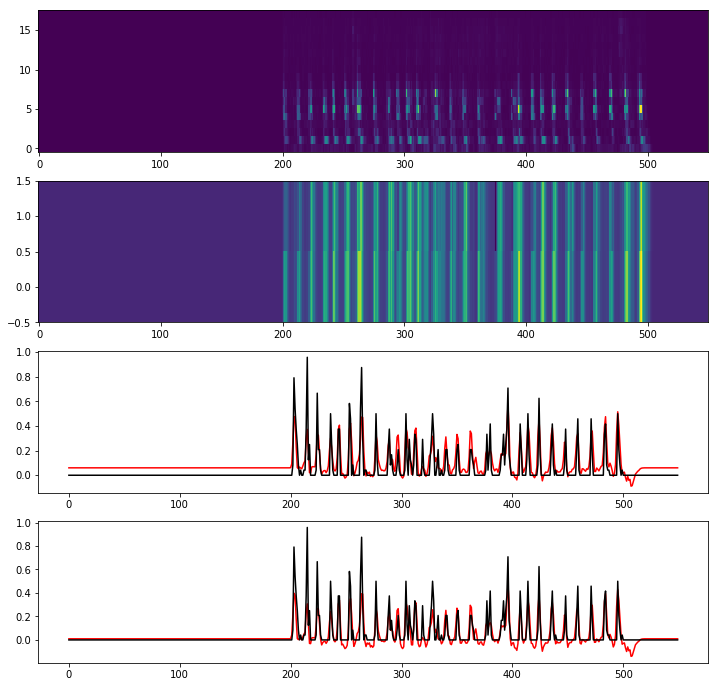

In [51]:
f, axes = pl.subplots(4, 1, figsize=(12, 12))
trial = 0

resp = stack.data[0].get_signal('resp').as_trials()[trial]

for i, ax in enumerate(axes):
    stim = stack.data[i].get_signal('pred').as_trials()[trial]
    if stim.shape[0] > 1:
        ax.imshow(stim, origin='lower', aspect='auto')
    else:
        ax.plot(stim[0], 'r-')
        ax.plot(resp[0], 'k-')

In [63]:
mod_gain.do_plot??

In [76]:
# test validation data
# PSEUDOCODE r=test_dumb_model(stack=stack,stim=X_val,resp=Y_val)

mod_corr = nm.metrics.correlation(stack)
stack.append(mod_corr)

stack.set_data(val)
stack.valmode = True
stack.evaluate()

#stack.plot_dataidx=1  # plot example trial from val dataset
#stack.quick_plot()


# TODO - save in JSON format with or without data matrix
# PSEUDOCODE: nu.io.save_dumb_model_as_json(stack)
#
# open questions/options
# 1. save only metadata and fit parameters
# 2. save metadata, fit parameters and input signals

nems.modules.base, 25 : creating module metrics.correlation



AttributeError: 'numpy.float64' object has no attribute 'get_signal'